In [1]:
import os

root_dir="/Users/jabbate/plasma-profile-predictor"
conf_filename=os.path.join(root_dir,'configs','trend_plus_actuators_joe.yaml')
model_filename=os.path.join(root_dir,'test_model.h5')

import numpy as np
psi_points=np.linspace(0,1,65)

In [2]:
import sys
# for some reason jupyter can't change the PYTHONPATH; neither with bash_profile nor with 
# os.system. so we add this to import helper functions
sys.path.insert(0,root_dir)

In [3]:
# matplotlib setup
%matplotlib inline

In [4]:
from helpers import helper_functions
import time

import tensorflow as tf
import numpy as np
from keras import models
from keras import layers
from keras import optimizers
import matplotlib.pyplot as plt
import yaml

Using TensorFlow backend.


In [5]:
config=helper_functions.load_config(conf_filename)

In [182]:
begin_time=time.time()
helper_functions.preprocess_data(**config['data_and_model'],
                                 **config['data'],
                                 save_data=True)
print(time.time()-begin_time)

Normalizing the same across all rho points


/miniconda3/lib/python3.6/site-packages/numpy/lib/nanfunctions.py:1426: RuntimeWarning: invalid value encountered in subtract
  np.subtract(arr, avg, out=arr, casting='unsafe')
/Users/jabbate/plasma-profile-predictor/helpers/helper_functions.py:32: RuntimeWarning: invalid value encountered in subtract
  a=obj-mean


Saving data to /Users/jabbate/data/...
1.715994119644165


In [7]:
input_dir=config['data']['output_dirname']

In [185]:
train_shot = helper_functions.load_obj(os.path.join(input_dir,'train_shot'))
val_shot = helper_functions.load_obj(os.path.join(input_dir,'val_shot'))
train_time = np.array(helper_functions.load_obj(os.path.join(input_dir,'train_time')))
val_time = np.array(helper_functions.load_obj(os.path.join(input_dir,'val_time')))

In [183]:
means = helper_functions.load_obj(os.path.join(input_dir,'means'))
stds = helper_functions.load_obj(os.path.join(input_dir,'stds'))

In [184]:
print('Means: ', means)
print('Stds: ', stds)

Means:  {'curr': 935392.4611100055, 'gasA': 1.1303357827551475, 'pinj': 3817.6441620437076, 'press': 3434.7616967907475, 'temp': 1.538893261837595, 'thomson_dens': inf, 'thomson_temp': inf}
Stds:  {'curr': 488253.8340439437, 'gasA': 1.6091280824646736, 'pinj': 2867.9360082624326, 'press': 10506.950312459207, 'temp': 0.6814838702714286, 'thomson_dens': 5.8694071958057255e+20, 'thomson_temp': 43566.419399394865}


In [11]:
loaded_model=models.load_model(model_filename)

loaded_model.compile(optimizer=optimizers.RMSprop(lr=.001),
                     metrics=['mae'], loss='mse')

In [12]:
loaded_model.summary()
from keras.utils import plot_model
plot_model(loaded_model,to_file='bad_model.png')

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
previous_actuators (InputLayer) (None, 11, 3)        0                                            
__________________________________________________________________________________________________
future_actuators (InputLayer)   (None, 4, 3)         0                                            
__________________________________________________________________________________________________
lstm_1 (LSTM)                   (None, 33)           4884        previous_actuators[0][0]         
__________________________________________________________________________________________________
lstm_2 (LSTM)                   (None, 33)           4884        future_actuators[0][0]           
__________________________________________________________________________________________________
previous_p

In [7]:
from data import get_datasets

In [ ]:
train_gen, valid_gen = get_datasets(batch_size=256,**config['data_and_model'],**config['data'])

Normalizing the same across all rho points


/miniconda3/lib/python3.6/site-packages/numpy/lib/nanfunctions.py:1426: RuntimeWarning: invalid value encountered in subtract
  np.subtract(arr, avg, out=arr, casting='unsafe')


> /Users/jabbate/plasma-profile-predictor/helpers/helper_functions.py(104)preprocess_data()
-> for sig in sigs:
(Pdb) l
 99  	        means[sig]=np.nanmean(means[sig])
100  	        stds[sig]=np.nanmean(stds[sig])
101  	
102  	    import pdb; pdb.set_trace()
103  	
104  ->	    for sig in sigs:
105  	        data_all_times[sig]=normalize(data_all_times[sig],means[sig],stds[sig])
106  	        data_all_times[sig]=remove_nans(data_all_times[sig])
107  	    for sig in sigs_1d+sigs_predict:
108  	        data_all_times[sig]=data_all_times[sig][:,::stride]
109  	
(Pdb) data_all_times['thomson_temp'].shape
(104292, 65)
--KeyboardInterrupt--
--KeyboardInterrupt--
--KeyboardInterrupt--


In [15]:
loaded_model.evaluate_generator(valid_gen)

[0.07218453981846139, 0.15784296047860297]

In [16]:
# Get ML model performance for full
predictions=loaded_model.predict_generator(valid_gen)

In [188]:
valid_gen_array=np.array(valid_gen)
prev_actuators=np.concatenate([elem[0] for elem in valid_gen_array[:,0]])
prev_profiles=np.concatenate([elem[1] for elem in valid_gen_array[:,0]])
future_actuators=np.concatenate([elem[2] for elem in valid_gen_array[:,0]])
targets=np.concatenate(np.array(valid_gen_array)[:,1])

In [18]:
val_mae=abs(targets-predictions)

In [19]:
avg_val_mae=np.mean(val_mae,axis=0)
std_val_mae=np.std(val_mae,axis=0)

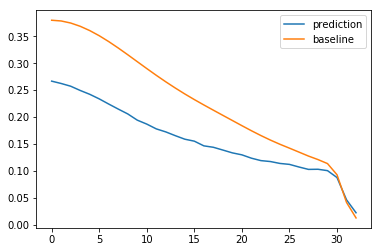

In [20]:
plt.plot(avg_val_mae, label='prediction')
plt.plot(np.mean(abs(targets),axis=0),label='baseline')
plt.legend()
plt.show()

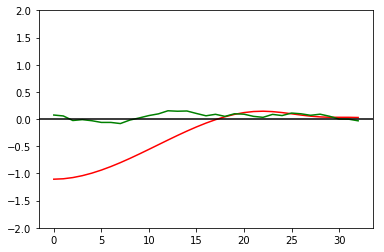

11250
164912
4400.0


In [173]:
idx=np.random.randint(len(targets))
#idx=3060 #2454 #9462 #<-- big transition
#idx=idx+1
plt.plot(targets[idx],c='r',label='true')
plt.plot(predictions[idx],c='g',label='predicted')
plt.ylim(-2,2)
plt.axhline(0,color='k')
plt.show()
print(idx)
print(val_shot[idx])
print(val_time[idx])

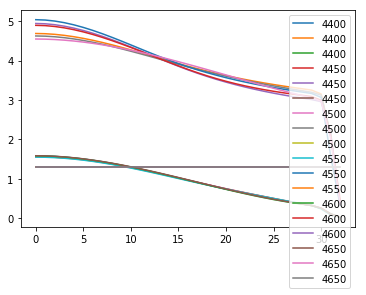

In [179]:
idx=3060

inds=range(idx-3,idx+3)
times=val_time[inds]
shots=val_shot[inds]
for i,ind in enumerate(inds):
    plt.plot(prev_profiles[ind]*stds['temp']+means['temp'],label=int(times[i]))
plt.legend()
plt.show()

In [ ]:
# The following must have already been run: 
# shot_indices_dictionary = helper_functions.load_obj(input_dir+'shot_indices')
# train_shots = shot_indices_dictionary['train_shot_names']
# val_shots = shot_indices_dictionary['val_shot_names']
# train_shot_inds = shot_indices_dictionary['train_shot_indices']
# val_shot_inds = shot_indices_dictionary['val_shot_indices']

def plot_timestep(index, train=False, normalized=True, 
                  sig_to_perturb=None):
    
    delay = config['data_and_model']['delay']
    titlesize=20
    othersize=20
    legendsize=15
    linewidth=7
    smalllinewidth=3
    
    if(train):
        data=train_data
        target=train_target
        shot_nums=train_shot
        true_times=train_time
    else:
        data=val_data
        target=val_target
        shot_nums=val_shot
        true_times=val_time
        
    shot_num=shot_nums[index]
    all_indices=np.where([shot_nums[index]==shot for shot in shot_nums])[0]
    
    input_data=[elem[index:index+1] for elem in data]
    #input_data[:,:,:3]=0
    
    pred=np.ndarray.flatten(loaded_model.predict(input_data))                      
    
    true=target[index]
    # note that timestep 0 will now throw an error 
    prev=target[index-1] #data[timestep][-1][num_sigs:]
    
    if normalized:
        pred_real=pred
        true_real=true
        prev_real=prev
    else:
        pred_real = np.multiply(pred,stds['temp'])+means['temp']
        true_real = np.multiply(true,stds['temp'])+means['temp']
        prev_real = (np.multiply(prev,stds['thomson_temp'])+means['thomson_temp'])/1000.
    
    sigs=data[0][index][-1]
    sigs_all_times=np.array(data[0])[all_indices,-delay-1,:].T
    
    fig = plt.figure()
    
    baseline_error = abs(true) #abs(true-prev)
    pred_error = abs(true-pred)
    
    ax = fig.add_subplot('222')
    ax.set_title('Electron temperature predictions by the ML model', fontsize=titlesize)
    ax.plot(rho_points,pred_real,label='Predicted', linewidth=smalllinewidth)
    
    
    #### FOR SENSITIVITY ANALYSIS ####
    if sig_to_perturb is not None:
        if sig_to_perturb in sig_keys_0d:
            sig_index=sig_keys_0d.index(sig_to_perturb)
        else:
            sig_index=range(len(sig_keys_0d),input_data.shape[2])

        input_data_perturbed=input_data.copy()


        # Flatline at the previous value
        input_data_perturbed[:,:,sig_index]=input_data_perturbed[:,0,sig_index]
        # Increase linearly
        #input_data_perturbed[:,:,sig_index]*=[1+i*.1 for i in range(input_data_perturbed.shape[1])]
        # add 10%
        #input_data_perturbed[:,:,sig_index] *= 1.1



        pred_perturbed=np.ndarray.flatten(loaded_model.predict(input_data_perturbed))
        if normalized:
            pred_perturbed_real=pred_perturbed
        else: 
            if config['n_components']!='None':
                # do the processing with pca, which was already loaded
                pred_perturbed = pca.inverse_transform(pred_perturbed)
            pred_perturbed_real = np.multiply(pred_perturbed,stds['e_temp'])+means['e_temp']
        ax.plot(rho_points,pred_perturbed_real,
                label='Predicted with perturbation to {}'.format(sig_to_perturb), 
                linewidth=smalllinewidth)
    ##################################
    
    
    ax.plot(rho_points,true_real,label='True', linewidth=smalllinewidth)
    #for differences
    if normalized:
        ax.axhline(0,label='Baseline',linewidth=smalllinewidth, color='k')
    else:
        ax.plot(rho_points,prev_real,label='Previous', linewidth=smalllinewidth)
    
    ax.set_ylabel('Normalized e_temp', fontsize=othersize)
    ax.set_xlim(0,1)
    #ax.set_xlabel('Normalized rho', fontsize=othersize)
    ax.legend(loc='best', fontsize=legendsize)
    
    ax = fig.add_subplot('224')
    ax.set_title('Error in e_temp predictions', fontsize=titlesize)
    ax.plot(rho_points, pred_error, color='red', label='Model error for one example', linewidth=linewidth)
    ax.plot(rho_points, avg_val_mae, color='red', linestyle='--', label='Average prediction error', linewidth=smalllinewidth)
    ax.fill_between(rho_points,avg_val_mae-std_val_mae, avg_val_mae+std_val_mae, color='red', alpha=.2)
    ax.axhline(0,color='k')
    ax.plot(rho_points, baseline_error, color='b', label='Baseline error for one example', linewidth=linewidth)
    ax.plot(rho_points, avg_baseline_mae, color='b', linestyle='--', label='Average baseline error', linewidth=smalllinewidth)
    ax.fill_between(rho_points,avg_baseline_mae-std_baseline_mae, avg_baseline_mae+std_baseline_mae, color='blue', alpha=.2)
    ax.set_ylim(0,.25)
    ax.set_xlim(0,1)
    ax.legend(loc='upper left', fontsize=legendsize)
    ax.set_ylabel('Error (abs val)', fontsize=othersize)
    ax.set_xlabel('Normalized rho', fontsize=othersize)
        
        #textstr='Baseline error: %.2f \nModel error: %.3f'%(np.mean(baseline_error),np.mean(pred_error))
        #ax.text(0.05,0.1,textstr, transform=ax.transAxes)
    
    #plt.subplots_adjust(hspace=.5)

    for i in range(len(sig_keys_0d)):
        which_plot='{}2{}'.format(len(sig_keys_0d)+len(sig_keys_1d),2*i+1) 
        ax=fig.add_subplot(which_plot) #axes[i+1]
        #ax.plot(times,sigs_all_times[i])
        if normalized:
            ax.plot(true_times[index],sigs_all_times[i])
            if sig_to_perturb is not None:
                if (i==sig_index):
                    ax.plot(true_times[index-config['lookback']:timestep+config['delay']+1],
                        input_data_perturbed[0,:,i],
                        linewidth=10)
        else:
            normalized_sig=(sigs_all_times[i]*stds[sig_keys_0d[i]])+means[sig_keys_0d[i]]
            ax.plot(true_times[times],normalized_sig)
        ax.set_ylabel(sig_keys_0d[i], fontsize=titlesize)
        ax.axvline(true_times[timestep],color='r')
        ax.axvline(true_times[timestep+delay],color='b')
            
    for i in range(len(sig_keys_1d)):
        which_plot='{}2{}'.format(len(sig_keys_0d)+len(sig_keys_1d),2*(len(sig_keys_0d)+i)+1) 
        ax=fig.add_subplot(which_plot) #axes[i+1]
        #ax.plot(times,sigs_all_times[i])
        rho_len_in = int((data.shape[2]-len(sig_keys_0d))/len(sig_keys_1d))
        if normalized:
            sig_trace_1d = np.mean(sigs_all_times[len(sig_keys_0d)+i*rho_len_in:len(sig_keys_0d)+(i+1)*rho_len_in],axis=0)
            ax.plot(true_times[times],sig_trace_1d)
        else:
            tmp = sigs_all_times[len(sig_keys_0d)+i*rho_len_in:len(sig_keys_0d)+(i+1)*rho_len_in]
            if config['n_components']!='None':
                # do the processing with pca, which was already loaded
                tmp = pca.inverse_transform(tmp)
            # convert back by multiplying by std, adding mean
            sig_trace_1d = (stds[sig_keys_1d[i]].dot(tmp)+sum(means[sig_keys_1d[i]]))/rho_len_in
            ax.plot(true_times[times],sig_trace_1d)
        ax.set_ylabel('mean {}'.format(sig_keys_1d[i]), fontsize=titlesize)
        ax.axvline(true_times[timestep],color='r')
        ax.axvline(true_times[timestep+delay],color='b')
        if i==len(sig_keys_0d)+len(sig_keys_1d)-1:
            ax.set_xlabel('Time (ms)', fontsize=othersize)
    
    fig.suptitle('Shot {} (timestep {})'.format(shot_num,timestep))
    plt.show()

In [ ]:
plt.rcParams['figure.figsize'] = [20, 15]
font={'size': 20, 'weight': 'heavy'}
plt.rc('font', **font)

In [ ]:
import random
timestep=random.randint(0,len(val_data))

#random.randint(0,len(train_data))
#timestep=np.random.choice(train_shot_inds)+np.random.randint(10)

#i+=2
#timestep=val_shot_inds[val_shots.index(163174)]+i
#timestep=val_shot_inds[42]+20
timestep=918
plot_timestep(timestep, train=False, normalized=True, sig_to_perturb=None)

In [ ]:
def plot_timestep_creative(timestep, train=False, normalized=True, 
                  perturbations=[], sig_to_perturb='pinj'):
    
    delay = config['delay']
    titlesize=20
    othersize=20
    legendsize=15
    linewidth=7
    smalllinewidth=3
    
    if(train):
        data=train_data
        target=train_target
        shot_nums=train_shots
        shot_inds=train_shot_inds
        true_times=train_time
    else:
        data=val_data
        target=val_target
        shot_nums=val_shots
        shot_inds=val_shot_inds
        true_times=val_time
        
    index = np.searchsorted(shot_inds, timestep, side='right')-1
    times=list(range(shot_inds[index],shot_inds[index+1]))

    shot_num=shot_nums[index]
    
    input_data=np.array(data)[timestep:timestep+1]
    #input_data[:,:,:3]=0
    
    pred=np.ndarray.flatten(loaded_model.predict(input_data))                      
    
    true=target[timestep]
    # note that timestep 0 will now throw an error 
    prev=target[timestep-1] #data[timestep][-1][num_sigs:]
    
    if normalized:
        pred_real=pred
        true_real=true
        prev_real=prev
    else:
        pred_real = np.multiply(pred,stds['e_temp'])+means['e_temp']
        true_real = np.multiply(true,stds['e_temp'])+means['e_temp']
        prev_real = np.multiply(prev,stds['e_temp'])+means['e_temp']
    
    sigs=data[timestep][-1][:len(sig_keys_0d)] #pinj, tinj, curr
    sigs_all_times=np.array(data)[times,-delay-1,:].T
    
    fig = plt.figure()
    
    baseline_error = abs(true) #abs(true-prev)
    pred_error = abs(true-pred)
    
    ax = fig.add_subplot('222')
    ax.set_title('Electron temperature predictions by the ML model', fontsize=titlesize)
    ax.plot(rho_points,pred_real,label='Predicted', linewidth=smalllinewidth)
    
    
    #### FOR SENSITIVITY ANALYSIS ####
    if len(perturbations)>0:
        if sig_to_perturb in sig_keys_0d:
            sig_index=sig_keys_0d.index(sig_to_perturb)
        else:
            sig_index=range(len(sig_keys_0d),input_data.shape[2])
        for perturbation in perturbations:
            input_data_no_actuators=input_data.copy()
            input_data_no_actuators[:,:,sig_index]+=perturbation
            pred_no_actuators=np.ndarray.flatten(loaded_model.predict(input_data_no_actuators))

            if normalized:
                pred_no_actuators_real=pred_no_actuators
            else: 
                pred_no_actuators_real = np.multiply(pred_no_actuators,stds['e_temp'])+means['e_temp']

            ax.plot(rho_points,pred_no_actuators_real,
                    label='Predicted with {} additional std to {}'.format(perturbation, sig_to_perturb), 
                    linewidth=smalllinewidth)
    ##################################
    
    
    ax.plot(rho_points,true_real,label='True', linewidth=smalllinewidth)
    #for differences
    ax.axhline(0,label='Baseline',linewidth=smalllinewidth, color='k')
    ### For regular:
    #ax.plot(rho_points,prev_real,label='Previous', linewidth=smalllinewidth)
    
    ax.set_ylabel('Normalized e_temp', fontsize=othersize)
    ax.set_xlim(0,1)
    #ax.set_xlabel('Normalized rho', fontsize=othersize)
    ax.legend(loc='best', fontsize=legendsize)
    
    ax = fig.add_subplot('224')
    ax.set_title('Error in e_temp predictions', fontsize=titlesize)
    ax.plot(rho_points, pred_error, color='red', label='Model error for one example', linewidth=linewidth)
    ax.plot(rho_points, avg_val_mae, color='red', linestyle='--', label='Average prediction error', linewidth=smalllinewidth)
    ax.fill_between(rho_points,avg_val_mae-std_val_mae, avg_val_mae+std_val_mae, color='red', alpha=.2)
    ax.axhline(0,color='k')
    ax.plot(rho_points, baseline_error, color='b', label='Baseline error for one example', linewidth=linewidth)
    ax.plot(rho_points, avg_baseline_mae, color='b', linestyle='--', label='Average baseline error', linewidth=smalllinewidth)
    ax.fill_between(rho_points,avg_baseline_mae-std_baseline_mae, avg_baseline_mae+std_baseline_mae, color='blue', alpha=.2)
    ax.set_ylim(0,.25)
    ax.set_xlim(0,1)
    ax.legend(loc='upper left', fontsize=legendsize)
    ax.set_ylabel('Error (abs val)', fontsize=othersize)
    ax.set_xlabel('Normalized rho', fontsize=othersize)
        
        #textstr='Baseline error: %.2f \nModel error: %.3f'%(np.mean(baseline_error),np.mean(pred_error))
        #ax.text(0.05,0.1,textstr, transform=ax.transAxes)
    
    #plt.subplots_adjust(hspace=.5)

    for i in range(len(sig_keys_0d)):
        which_plot='{}2{}'.format(len(sig_keys_0d)+len(sig_keys_1d),2*i+1) 
        ax=fig.add_subplot(which_plot) #axes[i+1]
        #ax.plot(times,sigs_all_times[i])
        if normalized:
            ax.plot(true_times[times],sigs_all_times[i])
        else:
            normalized_sig=(sigs_all_times[i]*stds[sig_keys_0d[i]])+means[sig_keys_0d[i]]
            ax.plot(true_times[times],normalized_sig)
        ax.set_ylabel(sig_keys_0d[i], fontsize=titlesize)
        ax.axvline(true_times[timestep],color='r')
        ax.axvline(true_times[timestep+delay],color='b')
            
    for i in range(len(sig_keys_1d)):
        which_plot='{}2{}'.format(len(sig_keys_0d)+len(sig_keys_1d),2*(len(sig_keys_0d)+i)+1) 
        ax=fig.add_subplot(which_plot) #axes[i+1]
        #ax.plot(times,sigs_all_times[i])
        rho_len_in = int((data.shape[2]-len(sig_keys_0d))/len(sig_keys_1d))
        if normalized:
            sig_trace_1d = np.mean(sigs_all_times[len(sig_keys_0d)+i*rho_len_in:len(sig_keys_0d)+(i+1)*rho_len_in],axis=0)
            ax.plot(true_times[times],sig_trace_1d)
        else:
            if config['n_components'] is not None:
                # do the processing with pca, which was already loaded
                pass
            print(sigs_all_times.shape)
            tmp = sigs_all_times[len(sig_keys_0d)+i*rho_len_in:len(sig_keys_0d)+(i+1)*rho_len_in]
            # convert back by multiplying by std, adding mean
            sig_trace_1d = (stds[sig_keys_1d[i]].dot(tmp)+sum(means[sig_keys_1d[i]]))/rho_len_in
            ax.plot(true_times[times],sig_trace_1d)
        ax.set_ylabel('mean {}'.format(sig_keys_1d[i]), fontsize=titlesize)
        ax.axvline(true_times[timestep],color='r')
        ax.axvline(true_times[timestep+delay],color='b')
        if i==len(sig_keys_0d)+len(sig_keys_1d)-1:
            ax.set_xlabel('Time (ms)', fontsize=othersize)
    
    fig.suptitle('Shot {} (timestep {})'.format(shot_num,timestep))
    plt.show()

In [ ]:
# The following must have already been run: 
# shot_indices_dictionary = helper_functions.load_obj(input_dir+'shot_indices')
# train_shots = shot_indices_dictionary['train_shot_names']
# val_shots = shot_indices_dictionary['val_shot_names']
# train_shot_inds = shot_indices_dictionary['train_shot_indices']
# val_shot_inds = shot_indices_dictionary['val_shot_indices']

def plot_presentation_ready(timestep, train=False, normalized=True, 
                  sig_to_perturb='pinj'):
    
    titlesize=50
    othersize=50
    legendsize=30
    linewidth=15
    smalllinewidth=10
    
    delay = config['delay']
    
    if(train):
        data=train_data
        target=train_target
        shot_nums=train_shots
        shot_inds=train_shot_inds
        true_times=train_time
    else:
        data=val_data
        target=val_target
        shot_nums=val_shots
        shot_inds=val_shot_inds
        true_times=val_time
        
    index = np.searchsorted(shot_inds, timestep, side='right')-1
    times=list(range(shot_inds[index],shot_inds[index+1]))

    shot_num=shot_nums[index]
    
    input_data=np.array(data)[timestep:timestep+1]
    #input_data[:,:,:3]=0
    
    pred=np.ndarray.flatten(loaded_model.predict(input_data))                      
    
    true=target[timestep]
    # note that timestep 0 will now throw an error 
    prev=target[timestep-1] #data[timestep][-1][num_sigs:]
    
    if normalized:
        pred_real=pred
        true_real=true
        prev_real=prev
    else:
        pred_real = np.multiply(pred,stds['e_temp'])+means['e_temp']
        true_real = np.multiply(true,stds['e_temp'])+means['e_temp']
        prev_real = np.multiply(prev,stds['e_temp'])+means['e_temp']
    
    sigs=data[timestep][-1][:len(sig_keys_0d)] #pinj, tinj, curr
    sigs_all_times=np.array(data)[times,-delay-1,:].T
    
    fig = plt.figure()
    plt.plot(rho_points,pred_real,label='Model Prediction at t+1', linewidth=smalllinewidth,c='r')
    
    plt.plot(rho_points,true_real,label='True Profile at t+1', linewidth=linewidth,c='b',linestyle=':')
    #for differences
    plt.plot(rho_points, prev_real,label='Profile at t',linewidth=linewidth, color='k')
     
    #### FOR SENSITIVITY ANALYSIS ####
#     words_for_multipliers=['increasing', 'fixed', 'decreasing']
#     colors=['g','y','r']
#     multipliers=[1,0,-1]
#     for i in range(len(multipliers)):
#         multiplier=multipliers[i]
#         this_sig_index=sig_keys_0d.index(sig_to_perturb)
#         other_sig_indices=range(len(sig_keys_0d),input_data.shape[2])

#         input_data_perturbed=input_data.copy()

#         # Flatline at the previous value for other signals
#         input_data_perturbed[:,-delay:,other_sig_indices]=input_data_perturbed[:,-delay-1,other_sig_indices]
#         # Increase linearly for the supplied signal
#         input_data_perturbed[:,-delay:,this_sig_index]*=[1+(i+1)*multiplier for i in range(delay)]
#         # add 10%
#         #input_data_perturbed[:,:,sig_index] *= 1.1

#         pred_perturbed=np.ndarray.flatten(loaded_model.predict(input_data_perturbed))
#         if normalized:
#             pred_perturbed_real=pred_perturbed
#         else: 
#             if config['n_components'] is not None:
#                 # do the processing with pca, which was already loaded
#                 pred_perturbed = pca.inverse_transform(pred_perturbed)
#             pred_perturbed_real = np.multiply(pred_perturbed,stds['e_temp'])+means['e_temp']
#         plt.plot(rho_points,pred_perturbed_real,
#                 label='t+1 prediction, {} {}'.format(sig_to_perturb, words_for_multipliers[i]), 
#                 linestyle='--',
#                 color=colors[i],
#                 linewidth=smalllinewidth)
    ##################################
    
    #plt.title('Electron temperature profile prediction', fontsize=titlesize)    
    plt.ylabel('Electron temperature (keV)', fontsize=othersize)
    plt.xlabel('Spatial position (normalized)', fontsize=othersize)
    plt.xlim(0,1)
    #ax.set_xlabel('Normalized rho', fontsize=othersize)
    plt.legend(loc='best', fontsize=legendsize)
    
    print('Shot {}\nt={:0.0f} ms\nt+1={:0.0f} ms'.format(shot_num,true_times[timestep],true_times[timestep+delay]))
    plt.show()

In [ ]:
import random
random.randint(0,len(val_data))
timestep=np.random.choice(val_shot_inds)+np.random.randint(10)

#random.randint(0,len(train_data))
#timestep=np.random.choice(train_shot_inds)+np.random.randint(10)

#i+=2
#timestep=val_shot_inds[val_shots.index(163174)]+i

timestep=1419
print(timestep)
plot_presentation_ready(timestep, train=False, normalized=False, sig_to_perturb='pinj')

In [ ]:
# plt.plot(rho_points,avg_val_mae, c='r', alpha=.5)
# plt.plot(rho_points, avg_baseline_mae, c='b', alpha=.5)

baseline_real=np.multiply(avg_baseline_mae,stds['e_temp'])+means['e_temp']
baseline_std_real=np.multiply(std_baseline_mae,stds['e_temp'])+means['e_temp']
ml_real=np.multiply(avg_val_mae,stds['e_temp'])+means['e_temp']
ml_std_real=np.multiply(std_val_mae,stds['e_temp'])+means['e_temp']

plt.fill_between(rho_points, baseline_real - baseline_std_real, baseline_real + baseline_std_real, color='b', alpha=0.2)
plt.fill_between(rho_points, ml_real - ml_std_real, ml_real + ml_std_real, color='r', alpha=0.2)

#plt.plot(rho_points, avg_baseline_reg_mae, c='k', label='Baseline Linear Regression', linewidth=7.0)
plt.plot(rho_points, baseline_real, c='b', label='Baseline', linewidth=7.0)
plt.plot(rho_points,ml_real, c='r', label='ML', linewidth=7.0)
# plt.plot(rho_points,avg_val_mae_holdout, c='b', label='ML no actuators', linewidth=7.0)
# plt.fill_between(rho_points, avg_baseline_mae - std_baseline_mae, avg_baseline_mae + std_baseline_mae, color='b', alpha=0.2)
# plt.fill_between(rho_points, avg_val_mae - std_val_mae, avg_val_mae + std_val_mae, color='r', alpha=0.2)

leg=plt.legend(loc='upper right', edgecolor='k', borderaxespad=1.0, borderpad=1.5, labelspacing=1.0, fontsize=30)
leg.get_frame().set_linewidth(3.0)
#leg.get_frame().set_edgecolor('k')
#plt.title('Comparing prediction error with and without rho=30', fontweight='heavy', fontsize=40)
plt.xlabel('Normalized rho', fontweight='heavy', fontsize=30)
#plt.ylabel('(Model with rho=30) - (Model without rho=30)', fontweight='heavy', fontsize=30)
plt.axhline(0,c='k')
plt.xlim(0,1.0)
plt.show()